In [7]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_R2 import _dataset, VAE, study#, compare_distributions_binned_aux, compare_distributions_binned
from VAE_OPTIMIZATION_WD import compare_continuous, compare_integer

## Loading the Study

In [9]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 101
Best trial:
  Value: 0.9938682044608013
  Params: 
    alpha: 6116
    hidden_size: 33
    lr: 0.0005181071332200718
    n_layers_decoder: 2
    n_layers_encoder: 2
    n_units_decoder_l0: 265
    n_units_decoder_l1: 425
    n_units_encoder_l0: 160
    n_units_encoder_l1: 470
 TRIAL NUMBER: 74


### Optuna Graphs

In [10]:
optuna.visualization.plot_param_importances(study)

In [11]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [12]:
#name = "re-reconstruction_vs_data_trial_38" FOI O 38 DA RECONSTRUCTION!!!!!
#name = "r2-reconstruction_vs_data_trial_{}".format(trial.number)
name = f"CustomTrain_R2-Data_vs_Reconstruction_trial_{trial.number}"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[38], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=160, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=160, out_features=470, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=470, out_features=33, bias=True)
  )
  (hidden2mu): Linear(in_features=33, out_features=33, bias=True)
  (hidden2log_var): Linear(in_features=33, out_features=33, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=33, out_features=265, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=265, out_features=425, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=425, out_features=47, bias=True)
  )
)

### Load data

In [13]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(334164, 47)

## Check if z ~ N(0,1)

In [14]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(334164, 33)

<ipython-input-15-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



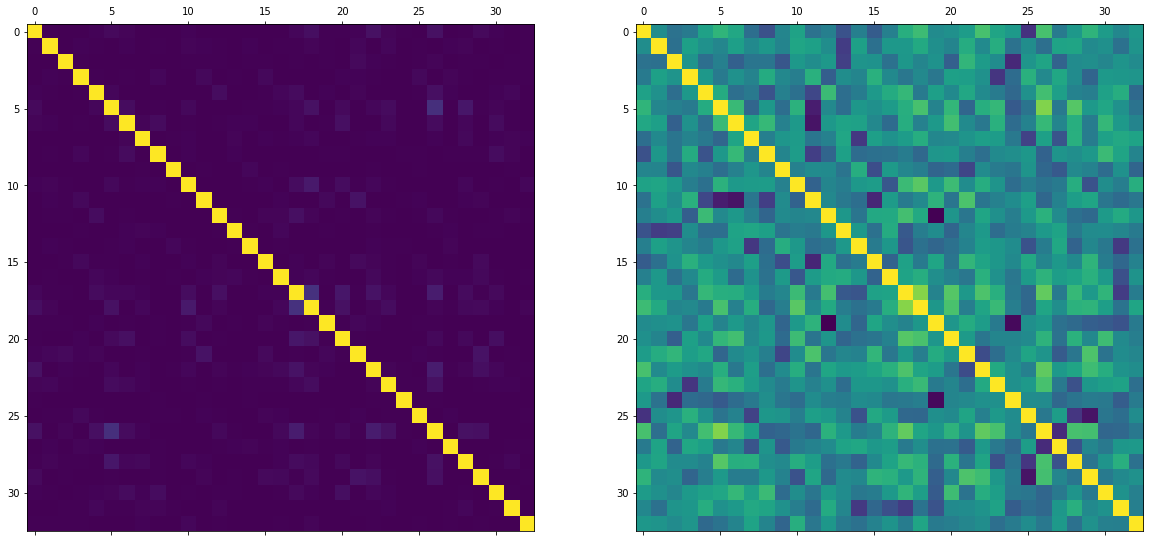

In [15]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [16]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.1421
Mean:	 0.00827


Mean: -0.0035176235 	Std: 1.0001888
Mean: -0.008377354 	Std: 1.0060937
Mean: -0.0077937455 	Std: 0.9734715
Mean: 0.0077732615 	Std: 0.990697
Mean: -0.019785183 	Std: 1.0039495
Mean: -0.0128511805 	Std: 0.99667656
Mean: -0.043433554 	Std: 0.999268
Mean: 0.01872465 	Std: 0.9992713
Mean: -0.00276758 	Std: 0.9932419
Mean: 0.00017812673 	Std: 0.9776931
Mean: -0.04132284 	Std: 0.97930866
Mean: 0.0084659215 	Std: 0.99636555
Mean: 0.023386147 	Std: 0.989515
Mean: 0.008546481 	Std: 0.98596996
Mean: 0.009245555 	Std: 0.993072
Mean: 0.012249336 	Std: 0.992293
Mean: 0.02528806 	Std: 0.9892426
Mean: 0.0077171586 	Std: 0.99717456
Mean: 0.00382771 	Std: 0.9957938
Mean: -0.0011344234 	Std: 0.9898713
Mean: -0.019399056 	Std: 0.9837575
Mean: 0.025485525 	Std: 0.99447525
Mean: 0.02175671 	Std: 1.0210836
Mean: -0.029631441 	Std: 1.0168644
Mean: 0.0034727484 	Std: 0.9842816
Mean: -0.026672494 	Std: 0.98825705
Mean: -0.029467167 	Std: 1.0222877
Mean: 0.0056268713 	Std: 0.99055904
Mean: -0.003519678 	Std: 1.

<ipython-input-17-2870a7d92efa>:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



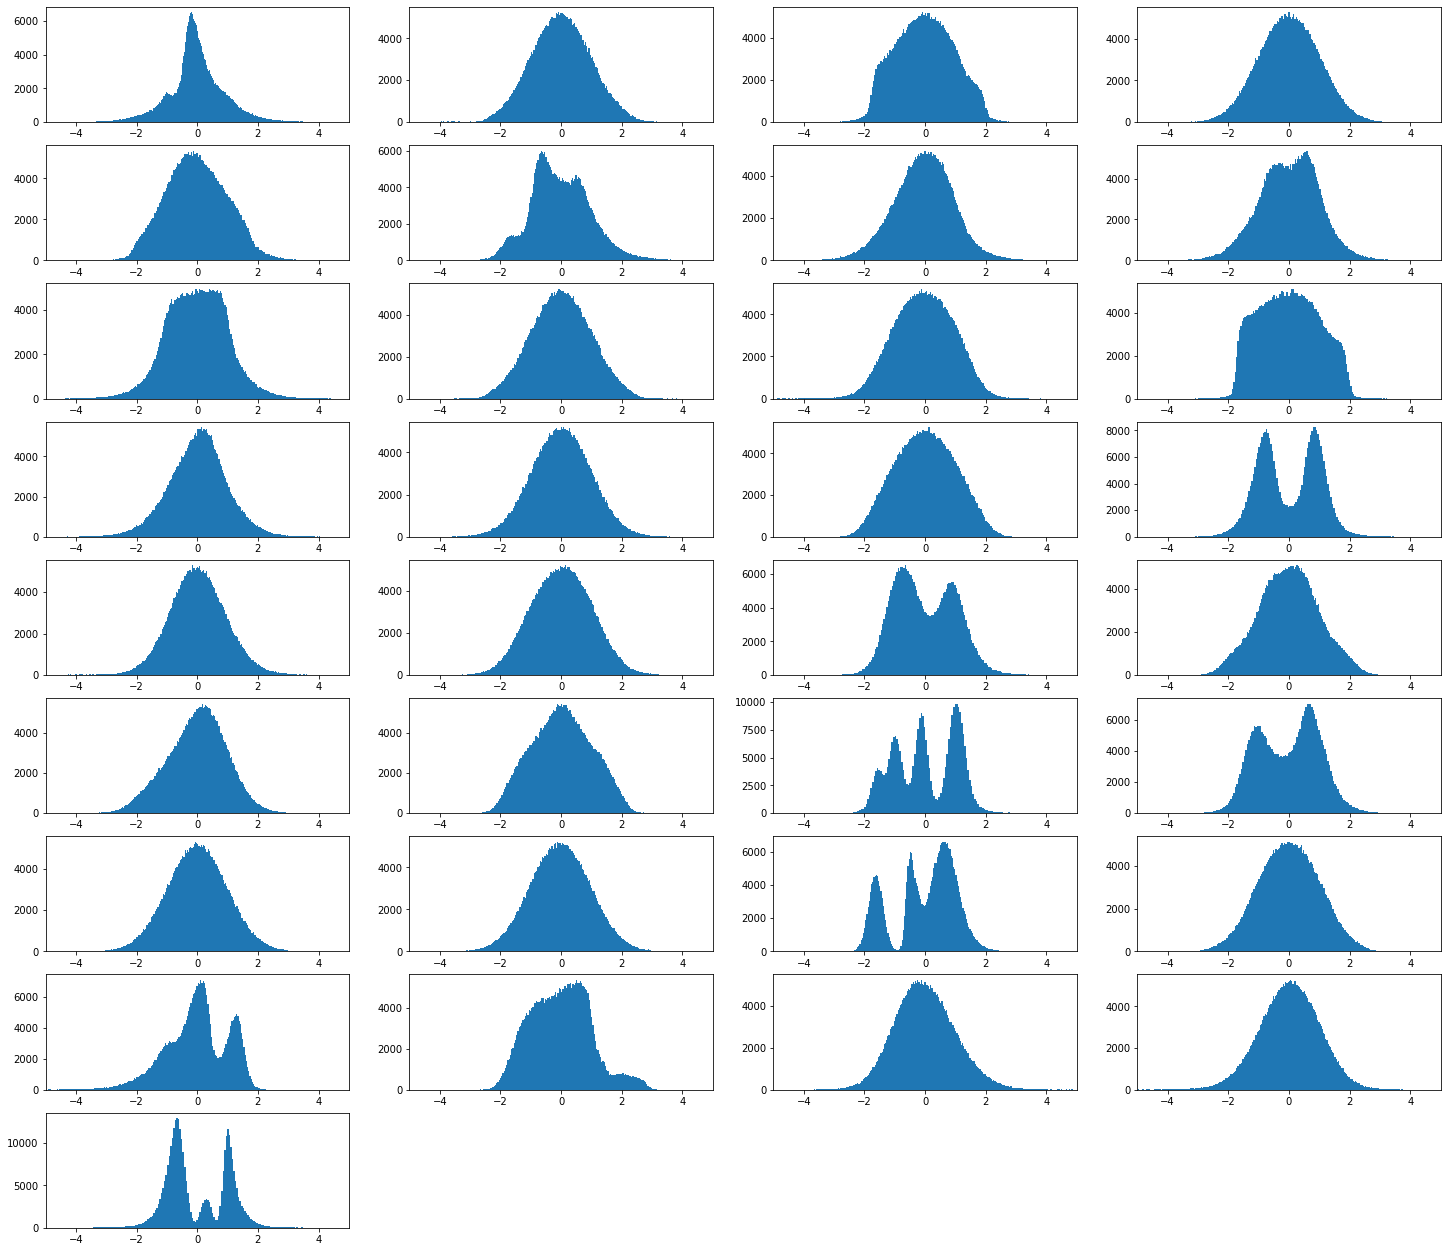

In [17]:

fig = plt.figure(figsize=[25,25])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(10,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

## Bkg Data vs Random Sampling Decoding

In [18]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
count,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,...,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000
mean,0.555923,0.225055,0.666037,-0.274271,-0.028168,0.470168,0.288129,0.391332,0.409122,0.394633,...,0.808721,-0.169688,1.134629,0.277902,-0.464142,1.025170,-0.068529,0.175537,-0.557876,-0.373394
std,0.462231,0.287839,0.290961,0.166979,0.345138,0.392864,0.369777,0.387592,0.401336,0.414806,...,0.306717,0.223621,0.359292,0.297306,0.196915,0.383360,0.299782,0.336212,0.464844,0.232290
min,-0.905541,-0.643864,-0.191508,-0.873426,-0.842894,-0.457492,-0.471259,-0.519253,-0.571470,-0.731316,...,-0.193486,-1.005304,-0.047498,-0.672928,-0.987287,0.127382,-0.695972,-0.762394,-1.292115,-1.085470
25%,0.210218,0.014681,0.453013,-0.392092,-0.290724,0.155757,-0.011614,0.053378,0.065832,0.048999,...,0.584153,-0.325294,0.898118,0.061310,-0.606241,0.700346,-0.323363,-0.070375,-1.133663,-0.543653
50%,0.217044,0.227184,0.668167,-0.279493,-0.069218,0.463457,0.246742,0.373004,0.389791,0.372433,...,0.808806,-0.173498,1.199691,0.277454,-0.473425,1.027439,-0.072721,0.169418,-0.216848,-0.392337
75%,1.128582,0.439729,0.877055,-0.162532,0.196486,0.786113,0.527198,0.721946,0.744588,0.729591,...,1.032400,-0.016230,1.408244,0.492499,-0.330618,1.352221,0.177609,0.411943,-0.210517,-0.209871
max,1.287432,1.201955,1.612627,0.446845,1.439053,1.586692,1.894736,1.319271,1.384628,1.452696,...,1.839337,0.745742,1.906896,1.254770,0.373093,1.775763,0.643277,1.241480,0.904808,0.531734


In [19]:
bkg.shape, sample.shape

((334164, 47), (334164, 47))

In [20]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += compare_distributions_binned_aux(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("WD_SCORE:", WD_SCORE/len(features))
    #print("WD_Score:", compare_distributions_binned(background, bkg_weights, sample, np.ones(bkg_weights.shape), bins=100))
    #print("R2_SCORE:", R2_SCORE/len(features))

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

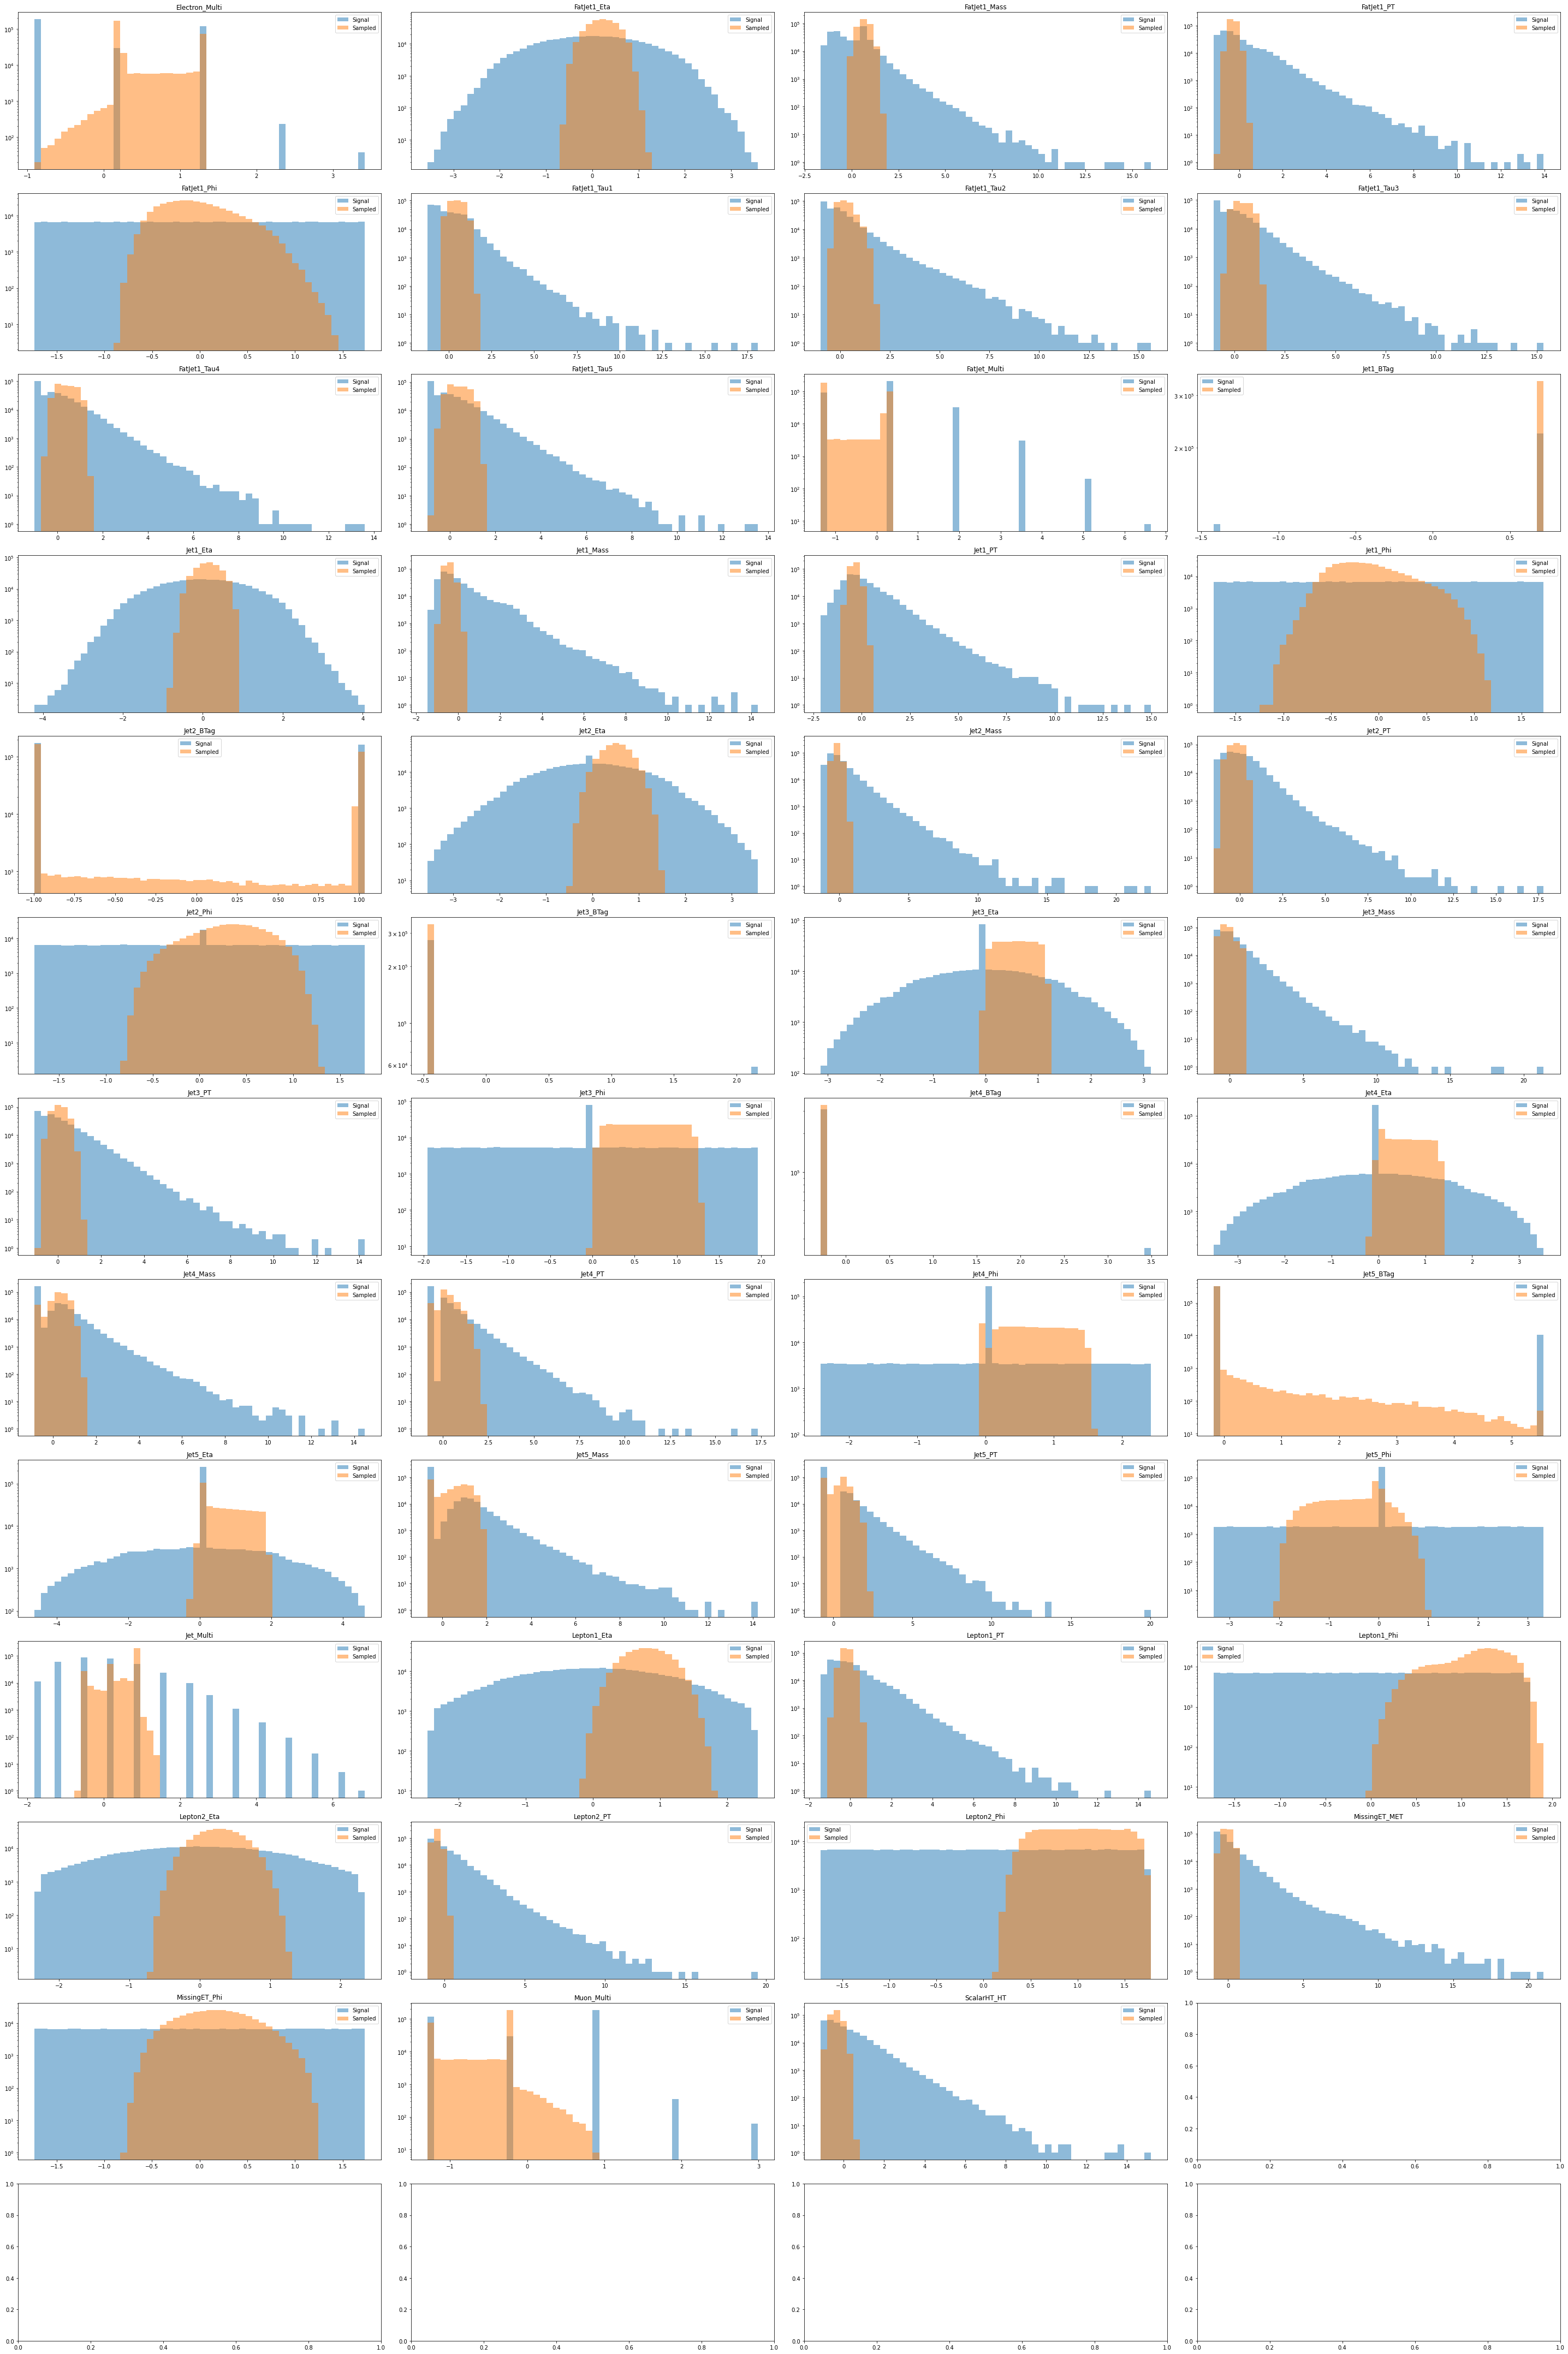

In [21]:
plot_graphs2(bkg, sample)

In [22]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 8.522771626211147


## Bkg Data vs Reconstruction

In [23]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

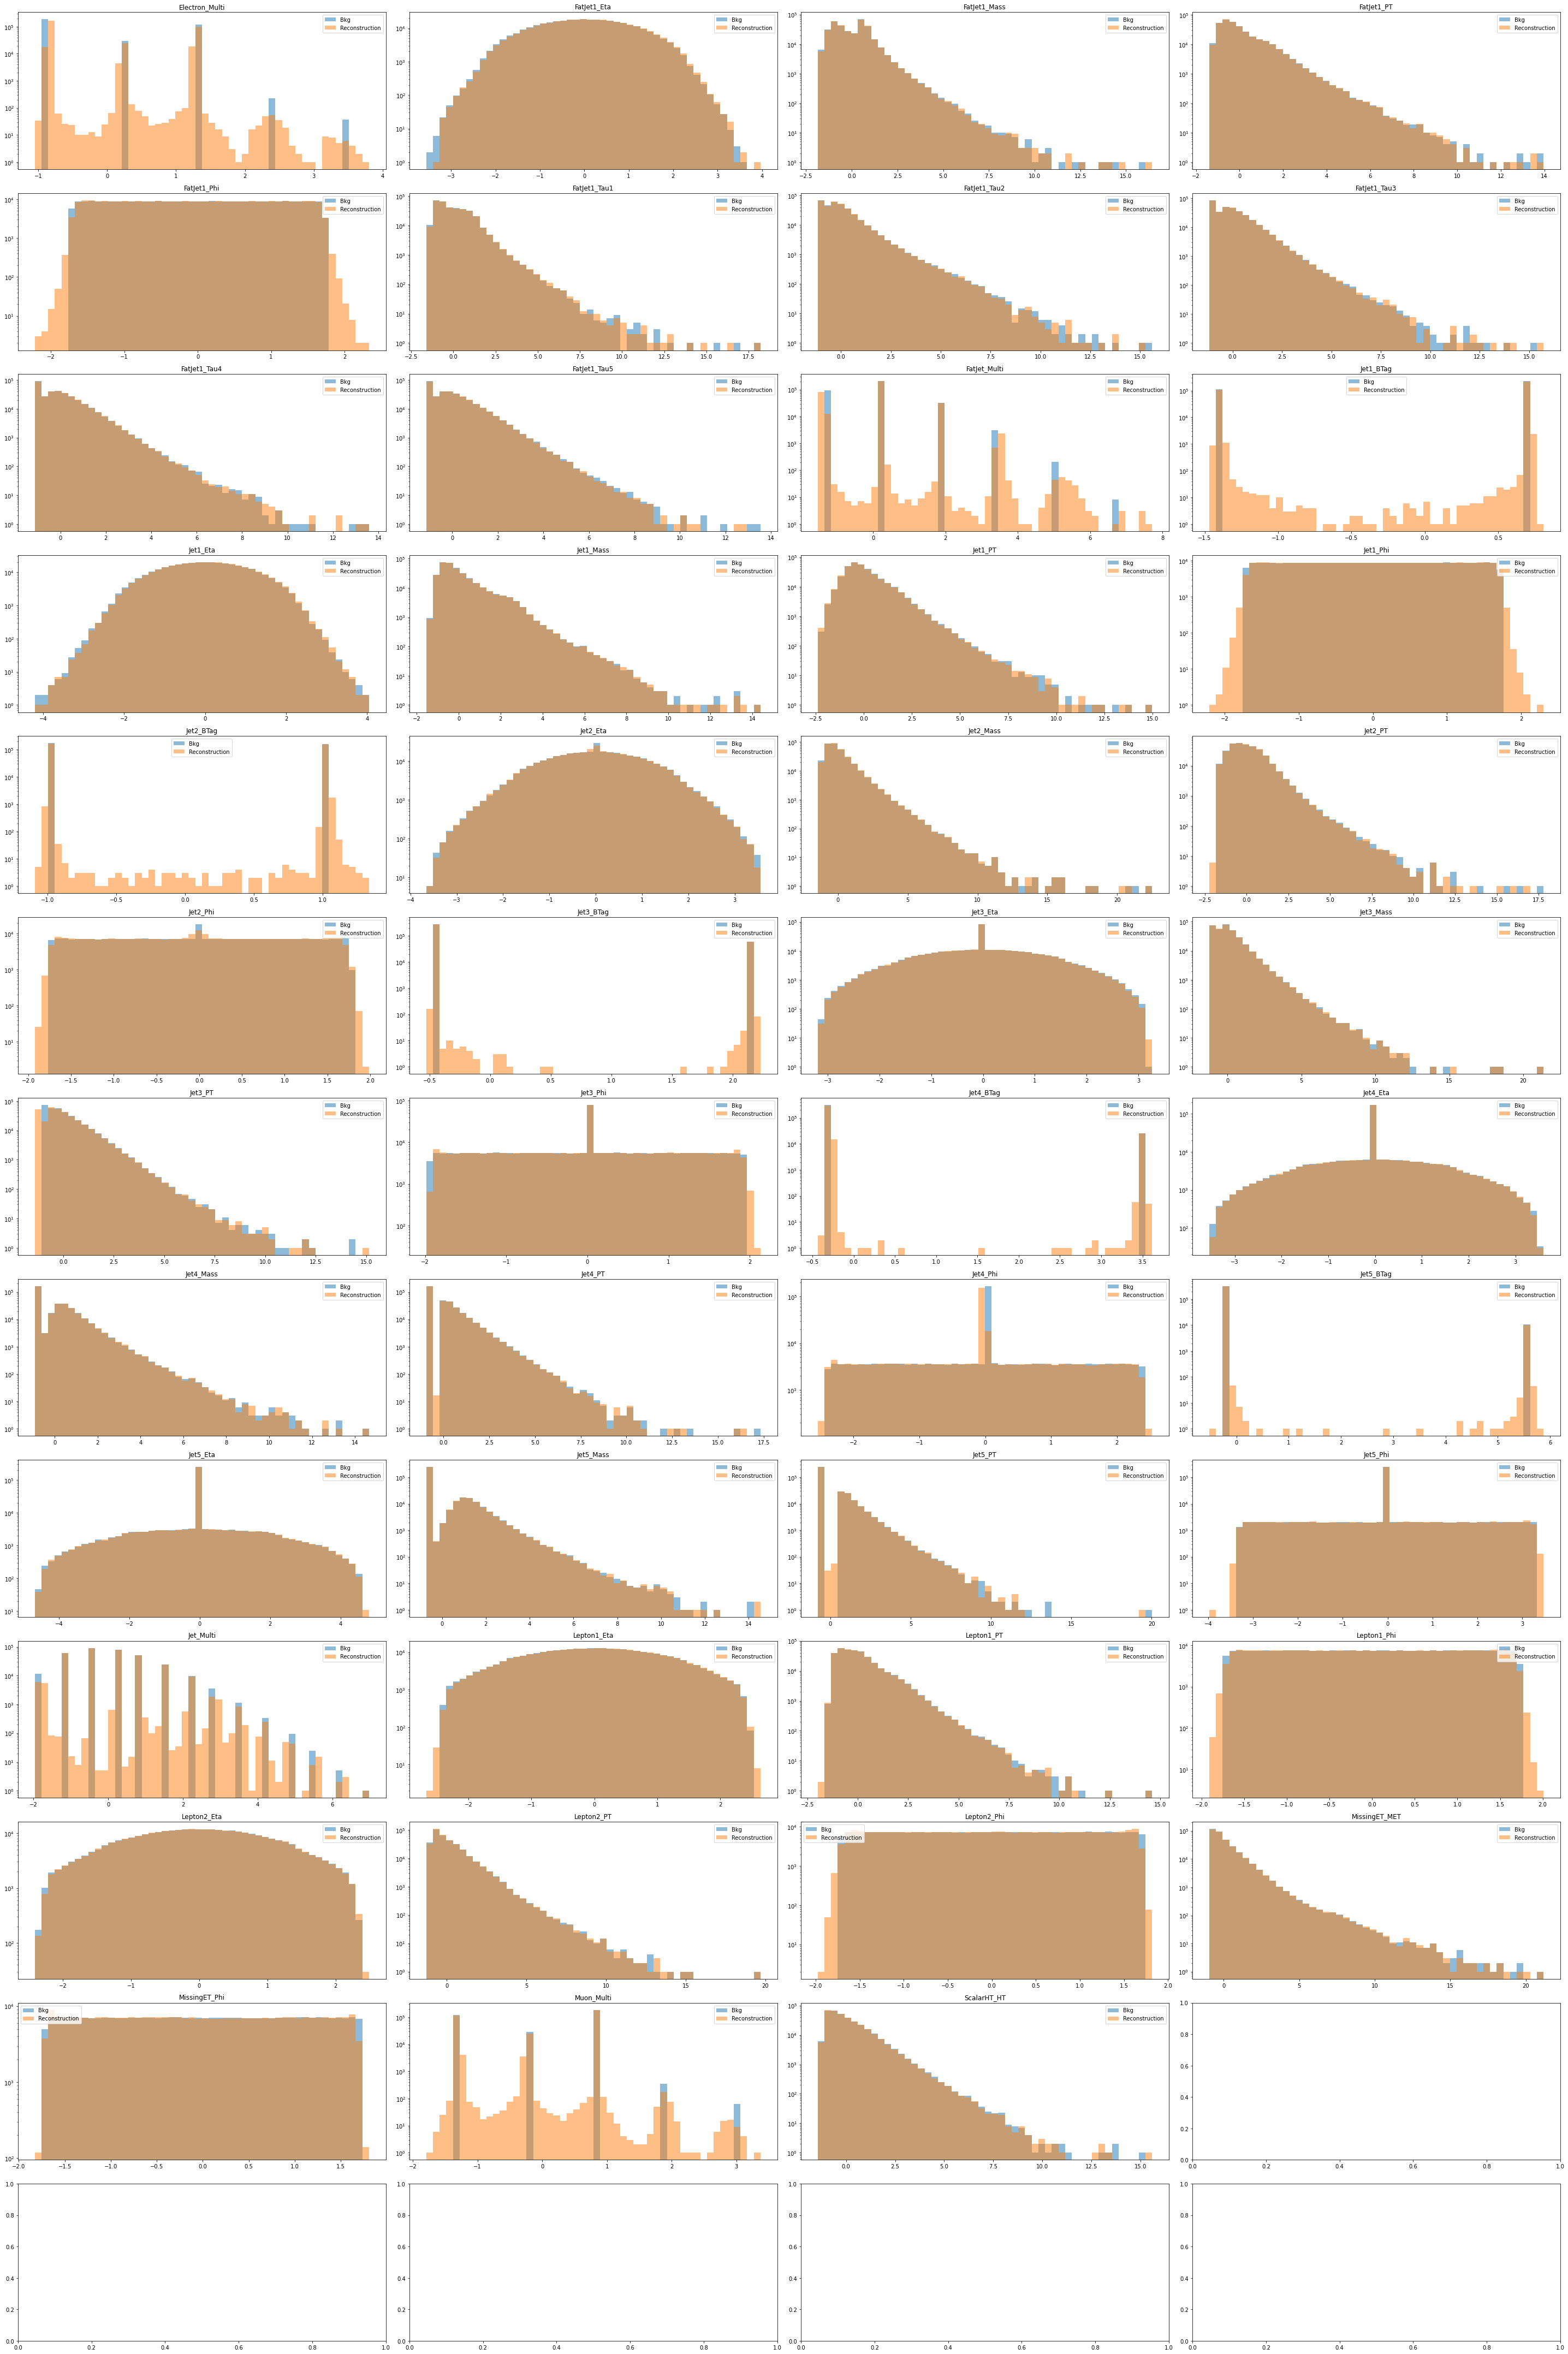

In [24]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [25]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.9967108456981112


## Plot error distributions and ROC Score

Load data

In [26]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)

data = pd.concat([signal, bkg])
del signal, bkg

Plot

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_graphs3(data, bins=50, num_cols=4):

    # Plot creation
    features = list(data['name'].unique())

    #num_rows = int(np.ceil((len(list(features)) - 1) / num_cols)) +1
    #fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    #i= 0


    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        #row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        #i += 1

        # Input to the model
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        #sData = sData[:min_value]
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        # Pass input through model
        _, _, output, _ = model.test_step(sData)

        # Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    # Now we are going to find the maximum of all distributions
    max_of_dist = max(map(lambda x: max(x), distributions.values()))

    # Normalize the distributions
    # This way all values should be between 0 and one
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist

    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    
    # PLOT error dist
    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        #x = x.replace(".h5", "")
        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

        # Plot rocs
        # ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    # PLOT ROC
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 
            score = score / max_of_dist

            #print(labels.shape, weights.shape, score.shape, x)
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))

    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for fcnc: 0.9952042071273141
ROC SCORE for hg3000_hq1400: 0.9999282083740496
ROC SCORE for hg3000_hq1200: 0.9999273638442783
ROC SCORE for wohg_hq1000: 0.9999243502073881
ROC SCORE for wohg_hq1200: 0.9999271673649184
ROC SCORE for hg3000_hq1000: 0.999925387998476
ROC SCORE for wohg_hq1400: 0.9999212157285841


<ipython-input-31-6951ca6cd7bd>:105: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



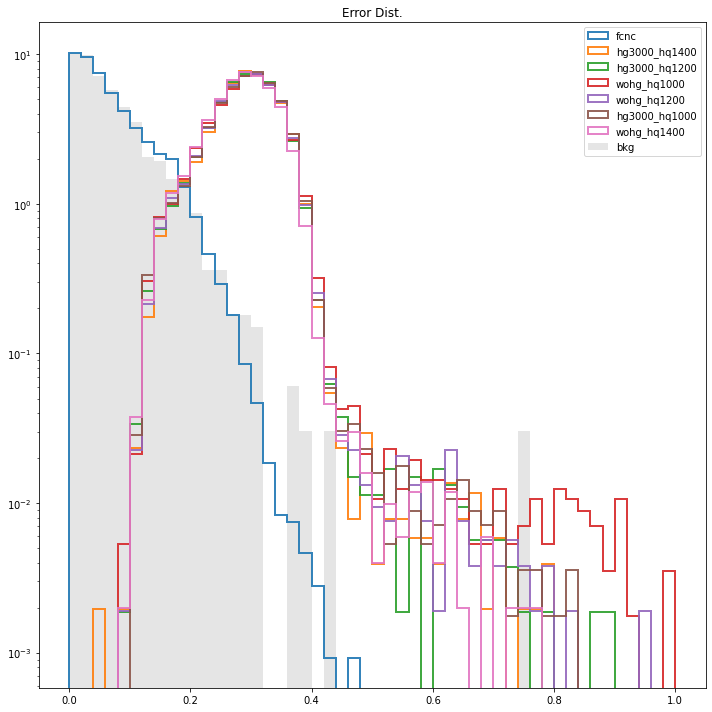

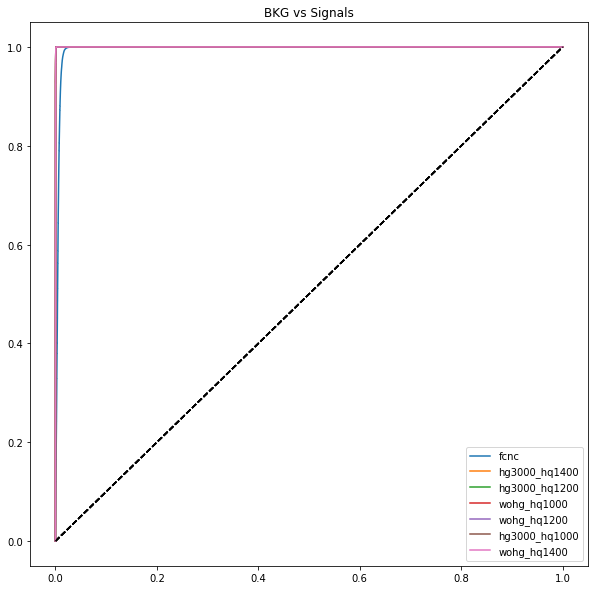

In [32]:
plot_graphs3(data)